In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import pyarrow.parquet

# Text Processing and NLP
import emoji
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Machine Learning
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


import os
from scipy.sparse import csr_matrix

# Download necessary NLTK data
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ngmin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Feature Extraction - Without Stopwords

In [2]:
df_train = pd.read_parquet("00_dataset/without_stopwords/tfidfWithNGram/train_features.parquet")
df_test = pd.read_parquet("00_dataset/without_stopwords/tfidfWithNGram/test_features.parquet")
df_val = pd.read_parquet("00_dataset/without_stopwords/tfidfWithNGram/val_features.parquet")

In [3]:
# Separate into X and y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

X_val = df_val.drop(columns=["label"])
y_val = df_val["label"]

In [4]:
print("Train Shape Before SVD:", X_train.shape)
print("Validation Shape Before SVD:", X_val.shape)
print("Test Shape Before SVD:", X_test.shape)

Train Shape Before SVD: (425920, 5009)
Validation Shape Before SVD: (60846, 5009)
Test Shape Before SVD: (121692, 5009)


In [5]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,4999,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length
count,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,...,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000
mean,0.001397,0.005073,0.000356,0.000334,0.001260,0.001107,0.000411,0.001514,0.002079,0.000918,...,0.000558,0.278932,0.790960,83.513348,1.185680,0.230445,0.040289,35.216484,0.000087,4.243544
std,0.015559,0.024068,0.007595,0.007951,0.013035,0.013542,0.008920,0.015152,0.016865,0.012223,...,0.010057,0.221031,0.379905,75.609372,2.818958,0.782845,0.028126,43.032663,0.016143,0.649589
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-0.999100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.151523,0.817300,33.000000,0.000000,0.000000,0.026764,9.000000,0.000000,3.969697
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.268981,0.942200,62.000000,0.000000,0.000000,0.035058,21.000000,0.000000,4.222222
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.399246,0.978700,109.000000,2.000000,0.000000,0.046667,45.000000,0.000000,4.492064
max,0.721809,0.944838,0.447479,0.548368,0.442913,1.000000,0.599298,0.578677,0.766244,0.607532,...,0.525805,1.000000,0.999800,1152.000000,1080.000000,56.000000,1.000000,1152.000000,8.000000,150.000000


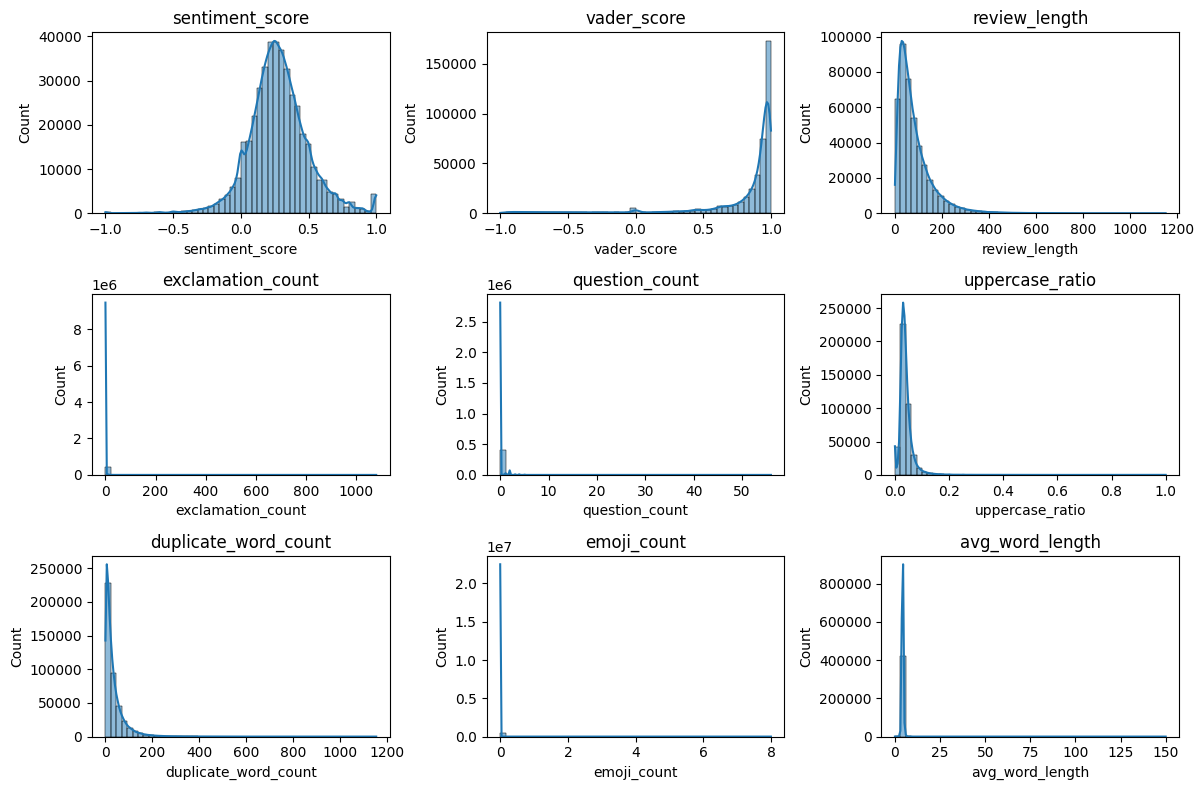

In [6]:
# Select extracted features
extracted_features = ["sentiment_score", "vader_score", "review_length", "exclamation_count",
                      "question_count", "uppercase_ratio", "duplicate_word_count", "emoji_count", "avg_word_length"]

# Plot histograms for extracted features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(extracted_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(X_train[feature], bins=50, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [4]:
# Select only extracted features
extracted_features = ["sentiment_score", "vader_score", "review_length", "exclamation_count",
                      "question_count", "uppercase_ratio", "duplicate_word_count", "emoji_count", "avg_word_length"]

# Apply MinMaxScaler only to extracted features
scaler = MinMaxScaler()
X_train[extracted_features] = scaler.fit_transform(X_train[extracted_features])
X_val[extracted_features] = scaler.transform(X_val[extracted_features])
X_test[extracted_features] = scaler.transform(X_test[extracted_features])

# Save the scaler for future use
joblib.dump(scaler, "00_dataset/without_stopwords/tfidfWithNGram/svd/minmax_scaler_extracted_features.joblib")

print("Extracted features scaled successfully!")

Extracted features scaled successfully!


In [8]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,4999,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length
count,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,...,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000,425920.000000
mean,0.001397,0.005073,0.000356,0.000334,0.001260,0.001107,0.000411,0.001514,0.002079,0.000918,...,0.000558,0.639466,0.895522,0.072494,0.001098,0.004115,0.040289,0.030570,0.000011,0.028290
std,0.015559,0.024068,0.007595,0.007951,0.013035,0.013542,0.008920,0.015152,0.016865,0.012223,...,0.010057,0.110516,0.190057,0.065633,0.002610,0.013979,0.028126,0.037355,0.002018,0.004331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.575762,0.908700,0.028646,0.000000,0.000000,0.026764,0.007812,0.000000,0.026465
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.634491,0.971184,0.053819,0.000000,0.000000,0.035058,0.018229,0.000000,0.028148
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.699623,0.989444,0.094618,0.001852,0.000000,0.046667,0.039062,0.000000,0.029947
max,0.721809,0.944838,0.447479,0.548368,0.442913,1.000000,0.599298,0.578677,0.766244,0.607532,...,0.525805,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


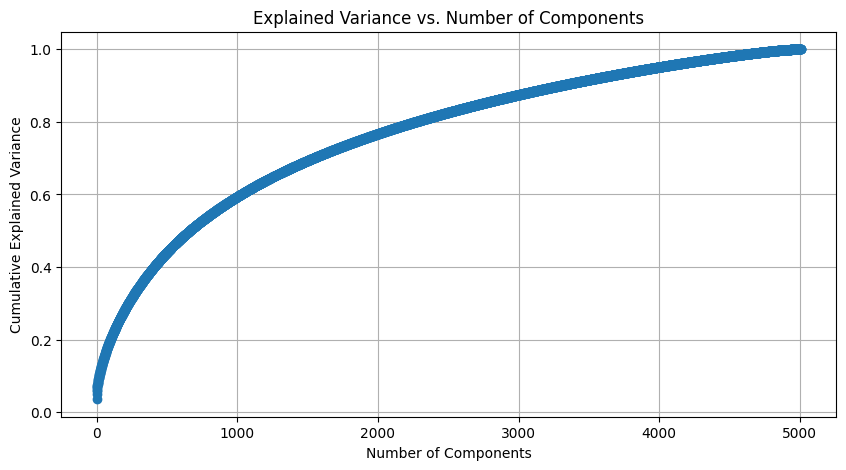

✅ Number of components explaining 95% variance: 3990
Optimal Number of Components: 3990


In [5]:
# 🔹 Step 1: Train Truncated SVD on Training Data
# Convert X_train to a sparse matrix for efficiency
X_train_sparse = csr_matrix(X_train)

# Define maximum components (adjust based on dataset)
max_components = min(5009, X_train.shape[1])

# Initialize Truncated SVD
svd = TruncatedSVD(n_components=max_components, random_state=42)

# Fit and transform data
X_train_svd = svd.fit_transform(X_train_sparse)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Find the number of components that explain 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"✅ Number of components explaining 95% variance: {optimal_n_components}")

threshold = 0.95
if np.any(cumulative_variance >= threshold):
    optimal_n_components = np.argmax(cumulative_variance >= threshold) + 1
else:
    optimal_n_components = len(cumulative_variance)  # Take max available components
    print(f"⚠️ Warning: 95% variance not reached. Using {optimal_n_components} components instead.")

print(f"Optimal Number of Components: {optimal_n_components}")

In [7]:
# 🔹 Step 5: Retrain SVD with the Optimal Number of Components
svd = TruncatedSVD(n_components=optimal_n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_sparse)

# 🔹 Step 6: Save Final SVD Model
joblib.dump(svd, "00_dataset/without_stopwords/tfidfWithNGram/svd/final_svd_model.joblib")
print("Final Truncated SVD model saved successfully!")

Final Truncated SVD model saved successfully!


In [8]:
# Load the saved SVD model
#svd = joblib.load("00_dataset/without_stopwords/tfidfWithNGram/svd/final_svd_model.joblib")

# Convert validation & test sets to sparse format (if not already)
X_val_sparse = csr_matrix(X_val)
X_test_sparse = csr_matrix(X_test)

# Transform validation and test sets using the trained SVD model
X_val_svd = svd.transform(X_val_sparse)
X_test_svd = svd.transform(X_test_sparse)

In [9]:
# Convert SVD-transformed data to DataFrame
X_train_svd_df = pd.DataFrame(X_train_svd)
X_val_svd_df = pd.DataFrame(X_val_svd)
X_test_svd_df = pd.DataFrame(X_test_svd)

In [ ]:
# Add column names (optional but recommended)
X_train_svd_df.columns = [f"svd_component_{i}" for i in range(X_train_svd.shape[1])]
X_val_svd_df.columns = [f"svd_component_{i}" for i in range(X_val_svd.shape[1])]
X_test_svd_df.columns = [f"svd_component_{i}" for i in range(X_test_svd.shape[1])]

# Save the transformed datasets
X_train_svd_df.to_parquet("00_dataset/without_stopwords/tfidfWithNGram/svd/X_train_svd.parquet", index=False)
X_val_svd_df.to_parquet("00_dataset/without_stopwords/tfidfWithNGram/svd/X_val_svd.parquet", index=False)
X_test_svd_df.to_parquet("00_dataset/without_stopwords/tfidfWithNGram/svd/X_test_svd.parquet", index=False)

AttributeError: 'Series' object has no attribute 'to_parquet'

In [20]:
# Convert labels (Series) to DataFrame before saving
y_train_df = y_train.to_frame()  # Convert Series to DataFrame
y_val_df = y_val.to_frame()
y_test_df = y_test.to_frame()

# Save the labels separately using the converted DataFrame
y_train_df.to_parquet("00_dataset/without_stopwords/tfidfWithNGram/svd/y_train.parquet", index=False)
y_val_df.to_parquet("00_dataset/without_stopwords/tfidfWithNGram/svd/y_val.parquet", index=False)
y_test_df.to_parquet("00_dataset/without_stopwords/tfidfWithNGram/svd/y_test.parquet", index=False)

In [12]:
X_test_svd_df.describe()

,svd_component_0,svd_component_1,svd_component_2,svd_component_3,svd_component_4,svd_component_5,svd_component_6,svd_component_7,svd_component_8,svd_component_9,...,svd_component_3980,svd_component_3981,svd_component_3982,svd_component_3983,svd_component_3984,svd_component_3985,svd_component_3986,svd_component_3987,svd_component_3988,svd_component_3989
count,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,...,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000,121692.000000
mean,1.118882,0.004398,0.007987,0.000350,0.000194,0.001926,0.000517,-0.000570,-0.000340,-0.000217,...,0.000015,-0.000006,0.000021,-0.000005,-0.000005,-0.000013,-0.000015,0.000027,-0.000028,-0.000004
std,0.192579,0.122481,0.088981,0.064469,0.059283,0.056303,0.054327,0.053338,0.052509,0.050454,...,0.007996,0.007992,0.007980,0.007971,0.007963,0.007926,0.007961,0.007951,0.007980,0.007970
min,0.043119,-0.504716,-0.376207,-0.347104,-0.227391,-0.261010,-0.319313,-0.297119,-0.277783,-0.201553,...,-0.069824,-0.084643,-0.055640,-0.061826,-0.053205,-0.053469,-0.060593,-0.051295,-0.067194,-0.052337
25%,1.110875,-0.076619,-0.047373,-0.039184,-0.038814,-0.034326,-0.035165,-0.033556,-0.035694,-0.033086,...,-0.004170,-0.004153,-0.004133,-0.004131,-0.004176,-0.004216,-0.004142,-0.004225,-0.004130,-0.004248
50%,1.180019,-0.001530,-0.010960,-0.004968,-0.003584,0.004333,-0.002793,0.000209,-0.003515,-0.005631,...,0.000045,0.000035,0.000079,-0.000030,-0.000037,-0.000079,-0.000009,0.000008,0.000009,-0.000038
75%,1.219694,0.081041,0.038289,0.030998,0.033573,0.040591,0.032813,0.033179,0.030496,0.025878,...,0.004309,0.004100,0.004255,0.004150,0.004189,0.003972,0.004186,0.004182,0.003989,0.004208
max,1.387943,0.589790,0.769514,0.543411,0.478743,0.299035,0.465002,0.333917,0.306542,0.492021,...,0.062131,0.053728,0.060934,0.076476,0.053684,0.052694,0.058961,0.060882,0.078385,0.055495


In [21]:
y_train_df.describe()

,label
count,425920.000000
mean,0.132201
std,0.338709
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [22]:
# Check shape
print(f"Train Shape: {X_train_svd_df.shape}, Labels: {y_train.shape}")
print(f"Validation Shape: {X_val_svd_df.shape}, Labels: {y_val.shape}")
print(f"Test Shape: {X_test_svd_df.shape}, Labels: {y_test.shape}")

# Check first few rows
display(X_train_svd_df.head())

# Check for missing values
print("Missing values in train dataset:", X_train_svd_df.isnull().sum().sum())
print("Missing values in validation dataset:", X_val_svd_df.isnull().sum().sum())
print("Missing values in test dataset:", X_test_svd_df.isnull().sum().sum())

Train Shape: (425920, 3990), Labels: (425920,)
Validation Shape: (60846, 3990), Labels: (60846,)
Test Shape: (121692, 3990), Labels: (121692,)


,svd_component_0,svd_component_1,svd_component_2,svd_component_3,svd_component_4,svd_component_5,svd_component_6,svd_component_7,svd_component_8,svd_component_9,...,svd_component_3980,svd_component_3981,svd_component_3982,svd_component_3983,svd_component_3984,svd_component_3985,svd_component_3986,svd_component_3987,svd_component_3988,svd_component_3989
0,1.166123,-0.082823,-0.029400,0.004932,-0.012882,0.027895,-0.009606,-0.034992,-0.015422,0.003984,...,0.008202,0.008132,-0.002553,0.000939,0.005750,0.006875,0.004669,0.004227,0.010915,-0.007799
1,1.147188,-0.015370,-0.097224,-0.041097,0.019241,0.020151,-0.010296,0.037120,-0.054258,0.003476,...,0.011383,0.029779,-0.010946,0.027791,0.003090,0.045448,0.003252,-0.001739,0.005372,0.013808
2,0.992670,-0.150463,-0.094194,0.026244,-0.011979,0.017180,0.053823,0.003188,-0.057951,0.018838,...,0.003308,0.000062,-0.003884,-0.000187,-0.001114,0.003879,-0.001278,0.002944,0.003366,-0.006679
3,1.203917,-0.050794,-0.009961,-0.038584,0.037613,-0.022178,-0.073087,0.054796,-0.055482,-0.056647,...,0.002079,0.002713,0.002428,0.001257,0.002192,-0.000332,0.000381,-0.003349,-0.000152,0.000045
4,1.144444,0.000430,-0.049184,0.014352,-0.025918,0.005802,-0.023318,-0.016356,-0.003851,-0.031184,...,-0.006579,0.017991,-0.008566,0.024206,0.003583,-0.008439,0.006017,0.030771,0.002516,0.001914


Missing values in train dataset: 0
Missing values in validation dataset: 0
Missing values in test dataset: 0
